In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, densenet121, inception_v3
from torchsummary import summary
from collections import OrderedDict
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.functional import softmax
import seaborn as sns
import wandb
import torch.nn.functional as F




INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [2]:
BATCH_SIZE = 8

In [6]:
# Define the directories for training, validation, and test sets
train_dir = './data_split/train'
val_dir = './data_split/val'
test_dir = './data_split/test'

# Print the number of images in each dataset and class Few, Many, None
print('Train:')
print('Few:', len(os.listdir(os.path.join(train_dir, 'Few'))))
print('Many:', len(os.listdir(os.path.join(train_dir, 'Many'))))
print('None:', len(os.listdir(os.path.join(train_dir, 'None'))))

print('Val:')
print('Val Few:', len(os.listdir(os.path.join(val_dir, 'Few'))))
print('Val Many:', len(os.listdir(os.path.join(val_dir, 'Many'))))
print('Val None:', len(os.listdir(os.path.join(val_dir, 'None'))))

print('Test:')
print('Test Few:', len(os.listdir(os.path.join(test_dir, 'Few'))))
print('Test Many:', len(os.listdir(os.path.join(test_dir, 'Many'))))
print('Test None:', len(os.listdir(os.path.join(test_dir, 'None'))))

Train:
Few: 3444
Many: 1302
None: 3258
Val:
Val Few: 1148
Val Many: 21
Val None: 181
Test:
Test Few: 1148
Test Many: 21
Test None: 182


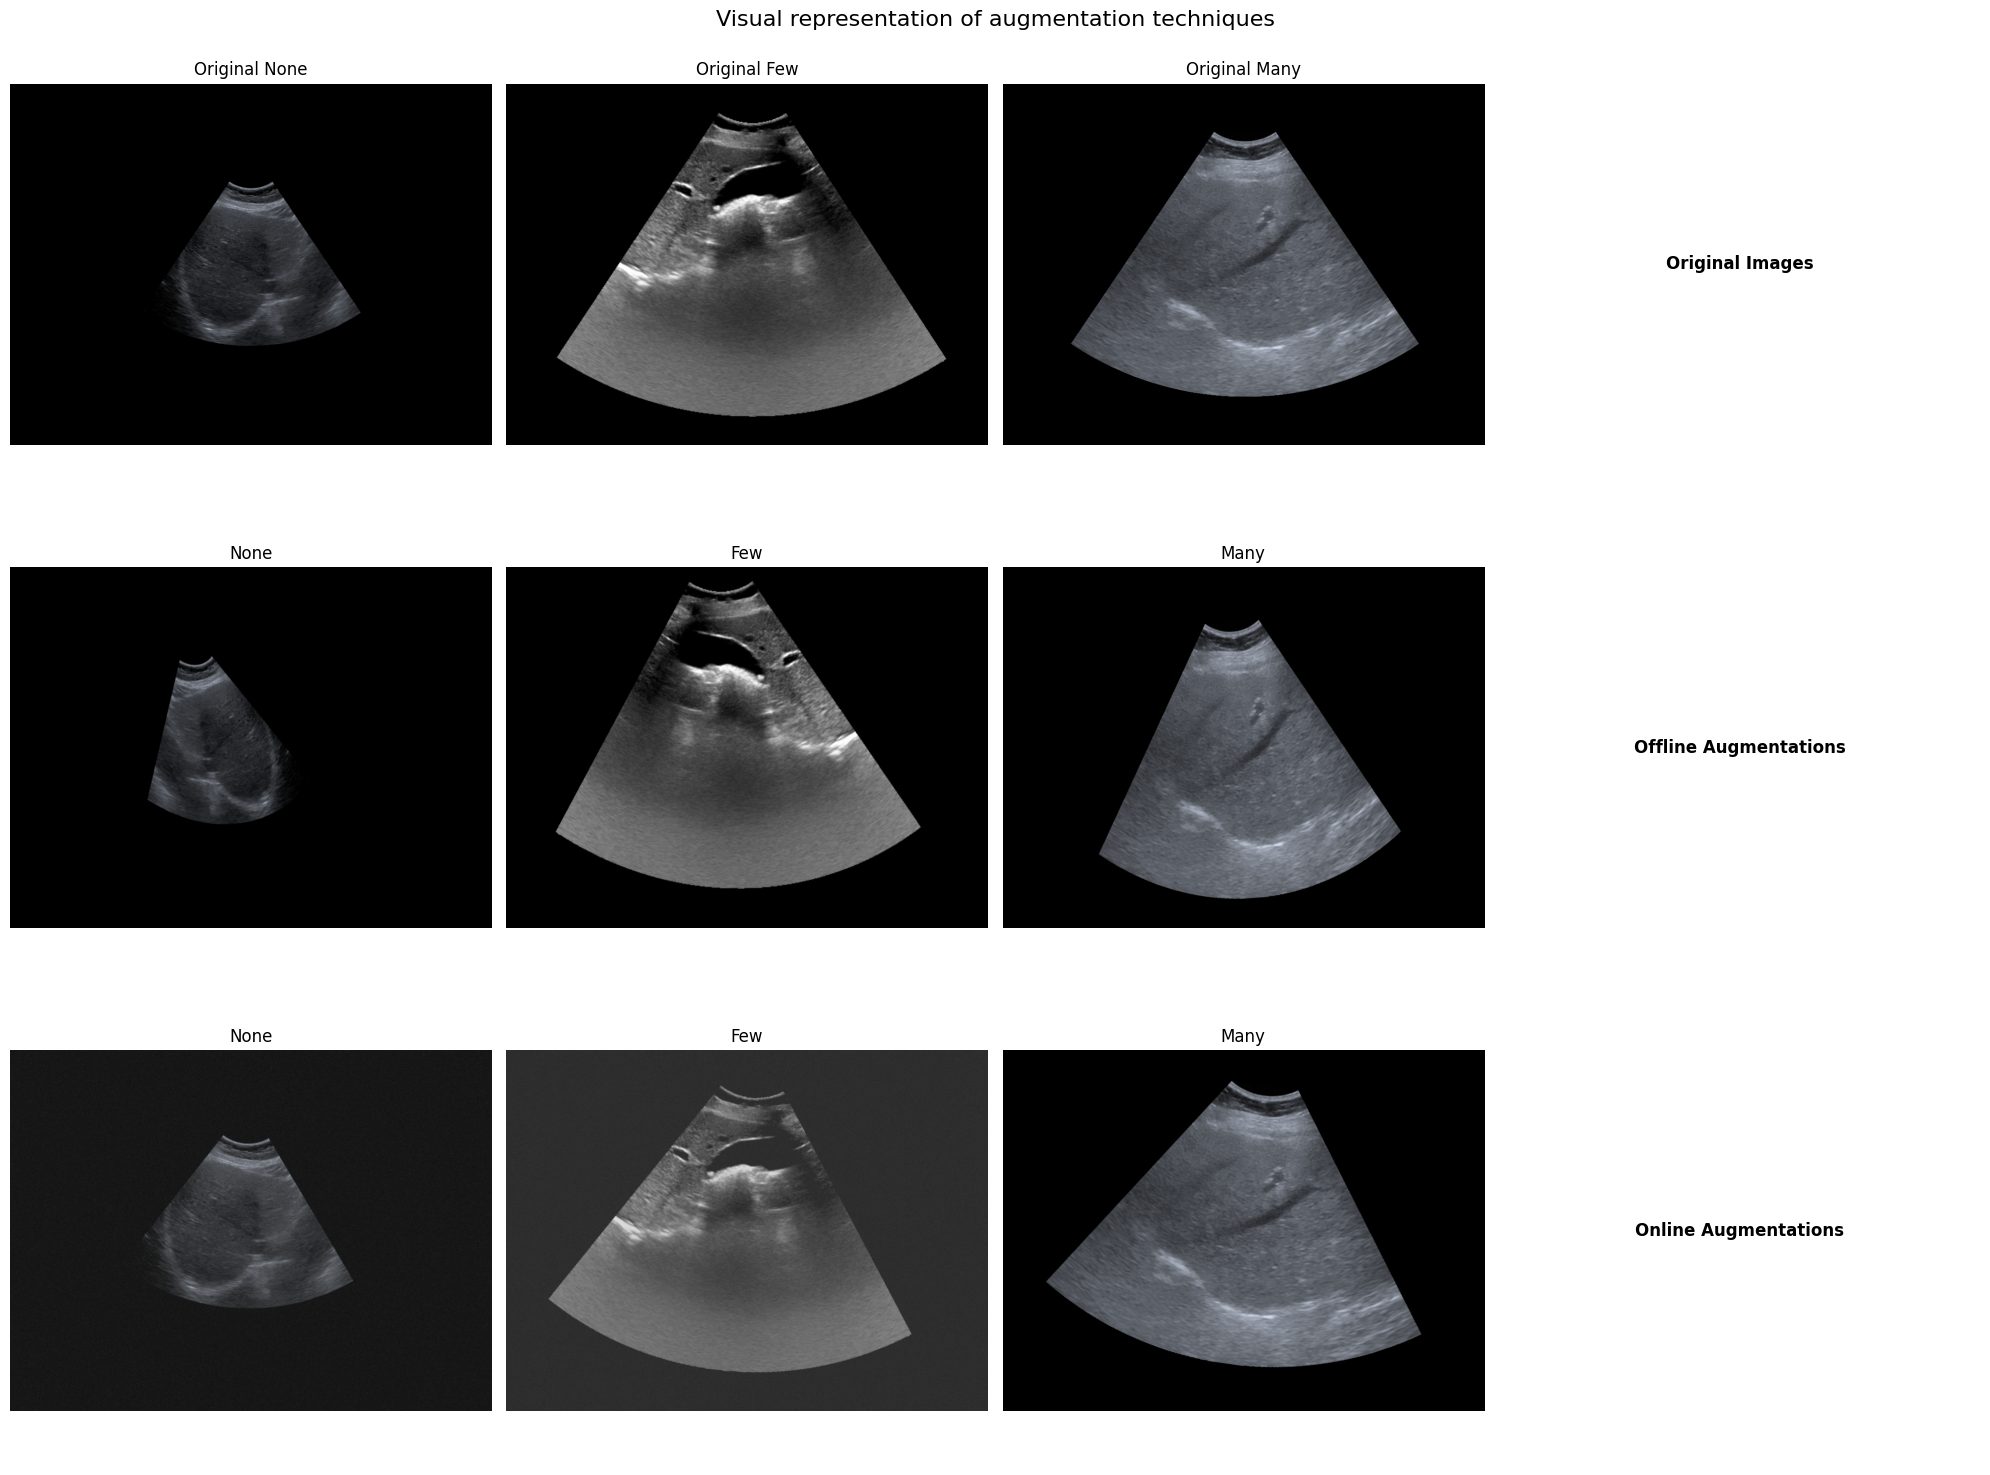

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import albumentations as A

# Function to load and preprocess image
def load_image(path):
    return np.array(Image.open(path))

# Load original images
none_img = load_image('/home/samo/dev/liver/PHASE_1/data_split/val/None/1.2.840.113619.2.116.3728688.1295159535.0.444.4.png')
few_img = load_image('/home/samo/dev/liver/PHASE_1/data_split/val/Few/1.2.840.113663.1500.1.388240827.3.53.20170208.115515.388.png')
many_img = load_image('/home/samo/dev/liver/PHASE_1/data_split/val/Many/1.2.840.113619.2.116.5609096.1328518429.0.1255.4.png')

# Define augmentations
offline_augs = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.1, rotate_limit=15),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1)
])

online_augs = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.GaussNoise(var_limit=(5.0, 20.0)),
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.1, rotate_limit=10)
])

# Apply augmentations
none_offline = offline_augs(image=none_img)['image']
few_offline = offline_augs(image=few_img)['image']
many_offline = offline_augs(image=many_img)['image']

none_online = online_augs(image=none_img)['image']
few_online = online_augs(image=few_img)['image']
many_online = online_augs(image=many_img)['image']

# Create the figure
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Visual representation of augmentation techniques', fontsize=16)

# Original images
axs[0, 0].imshow(none_img)
axs[0, 0].set_title('Original None')
axs[0, 1].imshow(few_img)
axs[0, 1].set_title('Original Few')
axs[0, 2].imshow(many_img)
axs[0, 2].set_title('Original Many')

# Offline augmentations
axs[1, 0].imshow(none_offline)
axs[1, 0].set_title('None')
axs[1, 1].imshow(few_offline)
axs[1, 1].set_title('Few')
axs[1, 2].imshow(many_offline)
axs[1, 2].set_title('Many')

# Online augmentations
axs[2, 0].imshow(none_online)
axs[2, 0].set_title('None')
axs[2, 1].imshow(few_online)
axs[2, 1].set_title('Few')
axs[2, 2].imshow(many_online)
axs[2, 2].set_title('Many')

# Remove axes for all subplots
for ax in axs.flat:
    ax.axis('off')

# Add legend or additional information in the last column
axs[0, 3].text(0.5, 0.5, 'Original Images', ha='center', va='center', fontsize=12, fontweight='bold')
axs[1, 3].text(0.5, 0.5, 'Offline Augmentations', ha='center', va='center', fontsize=12, fontweight='bold')
axs[2, 3].text(0.5, 0.5, 'Online Augmentations', ha='center', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('figure2_augmentations.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
class AugmentedDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=False):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.train = train
        self.classes = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx
        
        self.augment_classes = ['None', 'Many']
        self.augment_indices = [self.class_to_idx[cls] for cls in self.augment_classes if cls in self.class_to_idx]
        
        # Count samples per class
        self.class_counts = [0] * len(self.classes)
        for _, label in self.dataset.samples:
            self.class_counts[label] += 1
        
        # Calculate class weights once
        total_samples = sum(self.class_counts)
        self.class_weights = [total_samples / (len(self.class_counts) * count) for count in self.class_counts]
        
        if self.train:
            self.train_augs = A.Compose([
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # Reduced limits
                A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),  # Reduced upper var_limit
                A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.1, rotate_limit=10, p=0.5),])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        if self.train and label in self.augment_indices:
            img_np = np.array(img)
            augmented = self.train_augs(image=img_np)
            img_np = augmented['image']
            img = Image.fromarray(img_np)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

    def get_sample_weights(self):
        return [self.class_weights[label] for _, label in self.dataset.samples]

In [8]:

def create_weighted_sampler(dataset):
    sample_weights = dataset.get_sample_weights()
    return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Create datasets
train_dataset = AugmentedDataset(train_dir, transform=transform, train=True)
val_dataset = AugmentedDataset(val_dir, transform=transform, train=False)
test_dataset = AugmentedDataset(test_dir, transform=transform, train=False)

# Create samplers
train_sampler = create_weighted_sampler(train_dataset)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
#Figure 2: Visual representation of augmentation techniques applied to a sample image from each class
# Use one original image and one augmented image from each class

# Load one image from each class


FileNotFoundError: [Errno 2] No such file or directory: '/home/samo/dev/liver/PHASE_1/data_split/train/Few/1.jpg'

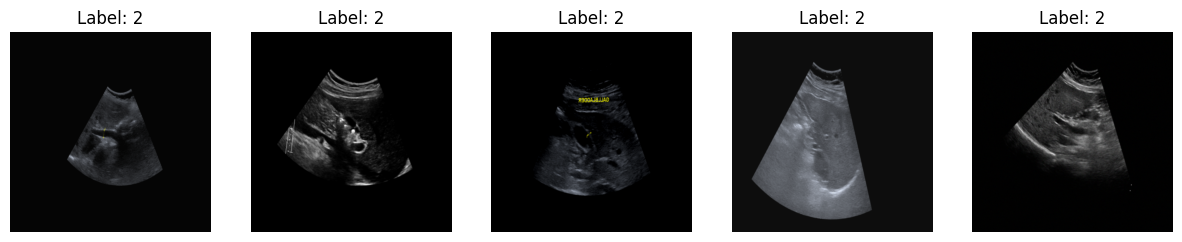

In [14]:
# Function to get images of a specific label
def get_images_by_label(dataloader, label, num_images=1):
    images = []
    labels = []
    for batch_images, batch_labels in dataloader:
        for img, lbl in zip(batch_images, batch_labels):
            if lbl == label:
                images.append(img)
                labels.append(lbl)
                if len(images) >= num_images:
                    return images, labels
    return images, labels

# Example usage: Get 5 images of label 0
label_to_display = 2
num_images_to_display = 5
images, labels = get_images_by_label(train_loader, label_to_display, num_images_to_display)

# Display the images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))
for i, (img, lbl) in enumerate(zip(images, labels)):
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f'Label: {lbl}')
    axes[i].axis('off')
plt.show()

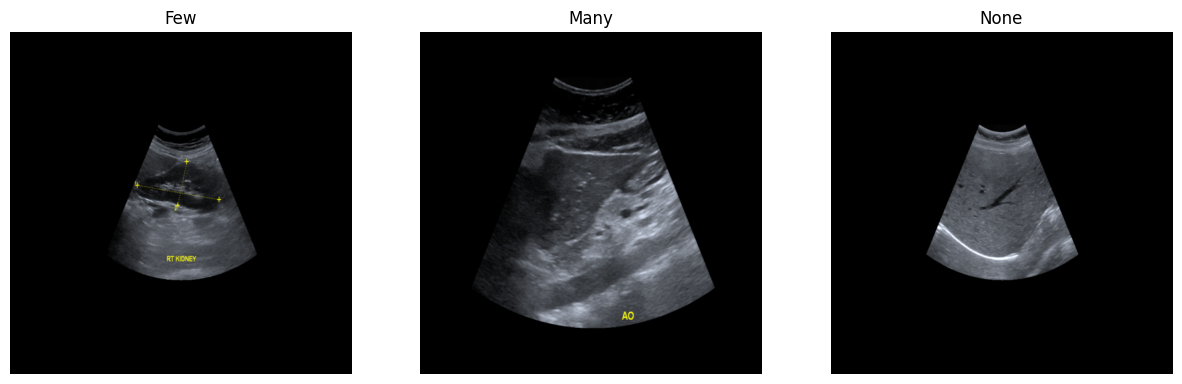

In [15]:
# Figure 2: Visual representation of augmentation techniques applied to a sample image from each class
# Use one original image and one augmented

im_few = get_images_by_label(val_loader, 0, 1)[0][0]
im_many = get_images_by_label(val_loader, 1, 1)[0][0]
im_none = get_images_by_label(val_loader, 2, 1)[0][0]

# Original images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(im_few.permute(1, 2, 0))
axes[0].set_title('Few')
axes[0].axis('off')
axes[1].imshow(im_many.permute(1, 2, 0))
axes[1].set_title('Many')
axes[1].axis('off')
axes[2].imshow(im_none.permute(1, 2, 0))
axes[2].set_title('None')
axes[2].axis('off')
plt.show()

# Augmented images


In [57]:
num_class = len(train_loader.dataset.classes)
print(num_class)
print(train_loader.dataset.classes)

3
['Few', 'Many', 'None']


In [58]:
class_weights = torch.tensor(train_dataset.class_weights, dtype=torch.float)
print(class_weights)
print(train_dataset.classes)

tensor([0.7747, 2.0492, 0.8189])
['Few', 'Many', 'None']


In [59]:
for batch in train_loader:
    print(batch[1])
    break

tensor([2, 2, 1, 1, 1, 0, 2, 2])


In [60]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

def calculate_metrics(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics for each class
    metrics = []
    sensitivities = []
    specificities = []
    
    for i in range(len(cm)):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - TP - FP - FN
        
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        
        metrics.append({
            'sensitivity': sensitivity,
            'specificity': specificity
        })
    
    # Calculate overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate ROC-AUC
    auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    
    # Calculate averaged sensitivity and specificity
    avg_sensitivity = sum(sensitivities) / len(sensitivities) if sensitivities else 0
    avg_specificity = sum(specificities) / len(specificities) if specificities else 0
    
    return accuracy, metrics, auc, cm, avg_sensitivity, avg_specificity

def plot_confusion_matrix(cm, class_names, epoch_num=0, model_name='model'):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'confusion_matrix_{model_name}_epoch{epoch_num}.png')
    plt.close()

def custom_log(metrics, model_name, log_dir='logs'):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    log_file = f'{log_dir}/{model_name}_metrics_log.json'
    with open(log_file, 'a') as f:
        f.write(json.dumps(metrics) + '\n')

In [61]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=1, device='cuda', model_name='model'):
    wandb.init(project="Hepatocyte Ballooning Detection", name=f"RadImageNet {model_name}")
    print(f'Training {model_name} for {num_epochs} epochs')
    min_valid_loss = np.inf
    best_metrics = {}
    class_names = ['None', 'Few', 'Many']
    
    for e in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []

        for i_batch, batch in enumerate(train_loader):
            data, labels = batch[0].to(device, dtype=torch.float), batch[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Validation phase
        model.eval()
        valid_loss = 0.0
        val_preds, val_labels, val_probs = [], [], []

        with torch.no_grad():
            for i_batch, batch in enumerate(val_loader):
                data, labels = batch[0].to(device, dtype=torch.float), batch[1].to(device)
                
                outputs = model(data)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * data.size(0)

                probs = F.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.cpu().numpy())

        # Calculate metrics
        val_accuracy, val_class_metrics, val_auc, val_cm, avg_sensitivity, avg_specificity = calculate_metrics(val_labels, val_preds, val_probs)

        print(f'Epoch {e+1}')
        val_loss = valid_loss / len(val_loader)
        train_loss /= len(train_loader)
        print(f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print(f'Validation AUC: {val_auc:.4f}')
        print(f'Averaged Sensitivity: {avg_sensitivity:.4f}, Averaged Specificity: {avg_specificity:.4f}')
        for i, metrics in enumerate(val_class_metrics):
            print(f'Class {class_names[i]} - Sensitivity: {metrics["sensitivity"]:.4f}, Specificity: {metrics["specificity"]:.4f}')

        # Log metrics to wandb and custom logger
        metrics = {
            'epoch': e + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_auc': val_auc,
            'avg_sensitivity': avg_sensitivity,
            'avg_specificity': avg_specificity,
            **{f'class_{class_names[i]}_sensitivity': metrics["sensitivity"] for i, metrics in enumerate(val_class_metrics)},
            **{f'class_{class_names[i]}_specificity': metrics["specificity"] for i, metrics in enumerate(val_class_metrics)}
        }

        # Log to wandb
        wandb.log(metrics)

        # Log to custom logger
        custom_log(metrics, model_name)

        # Save the best model
        if min_valid_loss > val_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{val_loss:.6f}) \t Saving The Model')
            min_valid_loss = val_loss
            best_metrics = {
                'val_loss': val_loss,
                'val_accuracy': val_accuracy,
                'val_auc': val_auc,
                'val_class_metrics': val_class_metrics,
                'val_confusion_matrix': val_cm,
                'avg_sensitivity': avg_sensitivity,
                'avg_specificity': avg_specificity
            }
            torch.save(model.state_dict(), f'best_{model_name}.pth')
            
            # Plot confusion matrix for the best model
            plot_confusion_matrix(val_cm, class_names, e, model_name)

    print("Best Validation Metrics:")
    print(f"Accuracy: {best_metrics['val_accuracy']:.4f}")
    print(f"AUC: {best_metrics['val_auc']:.4f}")
    print(f'Averaged Sensitivity: {best_metrics["avg_sensitivity"]:.4f}, Averaged Specificity: {best_metrics["avg_specificity"]:.4f}')
    for i, metrics in enumerate(best_metrics['val_class_metrics']):
        print(f'Class {class_names[i]} - Sensitivity: {metrics["sensitivity"]:.4f}, Specificity: {metrics["specificity"]:.4f}')
    wandb.finish()

    return model, best_metrics

In [62]:
class Classifier(nn.Module):
    def __init__(self, num_class, in_features=2048):
        super().__init__()
        self.drop_out = nn.Dropout()
        self.linear = nn.Linear(in_features, num_class)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.drop_out(x)
        x = self.linear(x)
        #x = torch.softmax(x, dim=-1)
        return x


class ResNetBackbone(nn.Module):
    def __init__(self, path, num_classes):
        super().__init__()
        resnet = resnet50(weights=None)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        
        state_dict = torch.load(path)
        new_state_dict = {}
        for k, v in state_dict.items():
            new_state_dict[k[9:]] = v

        print(self.backbone.load_state_dict(new_state_dict))  # <All keys matched successfully>
        
        self.classifier = Classifier(num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x
    

class DenseNetBackbone(nn.Module):
    def __init__(self, path, num_classes):
        super().__init__()
        base_model = densenet121(weights=None)
        encoder_layers = list(base_model.children())
        self.backbone = nn.Sequential(*encoder_layers[:-1])
        
        state_dict = torch.load(path)
        new_state_dict = {}
        for k, v in state_dict.items():
            new_state_dict[k[9:]] = v

        print(self.backbone.load_state_dict(new_state_dict))  # <All keys matched successfully>
        
        self.classifier = Classifier(num_classes, in_features=1024)
                        
    def forward(self, x):
        x = self.backbone(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
class InceptionBackbone(nn.Module):
    def __init__(self, path, num_classes):
        super().__init__()
        base_model = inception_v3(weights=None, aux_logits=False)
        encoder_layers = list(base_model.children())
        self.backbone = nn.Sequential(*encoder_layers[:-1])
        
        state_dict = torch.load(path)
        new_state_dict = {}
        for k, v in state_dict.items():
            new_state_dict[k[9:]] = v

        print(self.backbone.load_state_dict(new_state_dict))  # <All keys matched successfully>
        
        self.classifier = Classifier(num_classes)
                        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [63]:
models = os.listdir('models')
print(models)

['ResNet50.pt', 'DenseNet121.pt', 'InceptionV3.pt']


In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for model_name in models:
    if model_name == 'ResNet50.pt':
        model = ResNetBackbone(path=f'models/{model_name}', num_classes=num_class).to(device)
    elif model_name == 'DenseNet121.pt':
        model = DenseNetBackbone(path=f'models/{model_name}', num_classes=num_class).to(device)
    elif model_name == 'InceptionV3.pt':
        model = InceptionBackbone(path=f'models/{model_name}', num_classes=num_class).to(device)
    else:
        continue

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_model, best_metrics = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=2, device=device, model_name=model_name)

<All keys matched successfully>


wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 